In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [2]:
#open pretrained models for predicting delta y
sj_model = joblib.load('sj_rf.pkl')
iq_model = joblib.load('iq_rf.pkl')

In [3]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="quadratic", order=1)

    features['week_sin'] = np.sin(2 * np.pi * features['weekofyear']/53.0)
    features['week_cos'] = np.cos(2 * np.pi * features['weekofyear']/53.0)
    features = features.drop('weekofyear', axis=1)

    if labels is not None:
        features['delta_y'] = sj_model.predict(features.drop('total_cases', axis=1))
    else:
        features['delta_y'] = sj_model.predict(features)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)


def iq_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="quadratic", order=1)

    features['week_sin'] = np.sin(2 * np.pi * features['weekofyear']/53.0)
    features['week_cos'] = np.cos(2 * np.pi * features['weekofyear']/53.0)
    features = features.drop('weekofyear', axis=1)

    if labels is not None:
        features['delta_y'] = iq_model.predict(features.drop('total_cases', axis=1))
    else:
        features['delta_y'] = iq_model.predict(features)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)

In [4]:
tminus = 0
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=tminus,
                                                        iq_tminus=tminus)

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [5]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)


In [6]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,655.0,0.086158,0.096638,-0.290200,0.032292,0.082800,0.129210,0.446267
ndvi_nw,655.0,0.084960,0.106930,-0.567938,0.044733,0.085600,0.134550,0.437100
ndvi_se,655.0,0.170185,0.094370,-0.556810,0.140464,0.177643,0.212529,0.393129
ndvi_sw,655.0,0.163893,0.063279,-0.111362,0.129112,0.167943,0.203043,0.381420
precipitation_amt_mm,655.0,34.365767,41.398842,-15.492810,0.705000,21.530000,50.610000,287.550000
...,...,...,...,...,...,...,...,...
station_min_temp_c_16,655.0,22.563503,1.481789,17.800000,21.700000,22.800000,23.900000,25.600000
station_precip_mm_16,655.0,26.139326,28.834126,-8.089334,6.600000,16.800000,34.850000,305.900000
week_sin_16,655.0,0.003955,0.701226,-0.999561,-0.696551,0.002252,0.696551,0.999561
week_cos_16,655.0,-0.039253,0.695595,-0.998244,-0.717507,-0.051888,0.674983,1.000000


In [7]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,364.0,0.267057,0.081455,0.088616,0.204575,0.267829,0.323507,0.488400
ndvi_nw,364.0,0.233889,0.075983,0.035860,0.178186,0.226736,0.289986,0.428771
ndvi_se,364.0,0.251451,0.076860,0.029880,0.195130,0.250836,0.305611,0.473400
ndvi_sw,364.0,0.264058,0.083723,0.064183,0.206225,0.261300,0.321064,0.546017
precipitation_amt_mm,364.0,64.413590,34.986159,0.000000,39.452500,60.850000,86.507500,173.450000
...,...,...,...,...,...,...,...,...
station_min_temp_c_16,364.0,21.092781,1.471844,14.700000,20.400000,21.350000,22.200000,24.200000
station_precip_mm_16,364.0,44.582335,133.063011,-837.003741,14.800000,48.100000,88.200000,543.300000
week_sin_16,364.0,-0.032057,0.696036,-0.999561,-0.706872,-0.051967,0.652822,0.999561
week_cos_16,364.0,-0.005760,0.688096,-0.998244,-0.717507,-0.068291,0.674983,1.000000


In [8]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

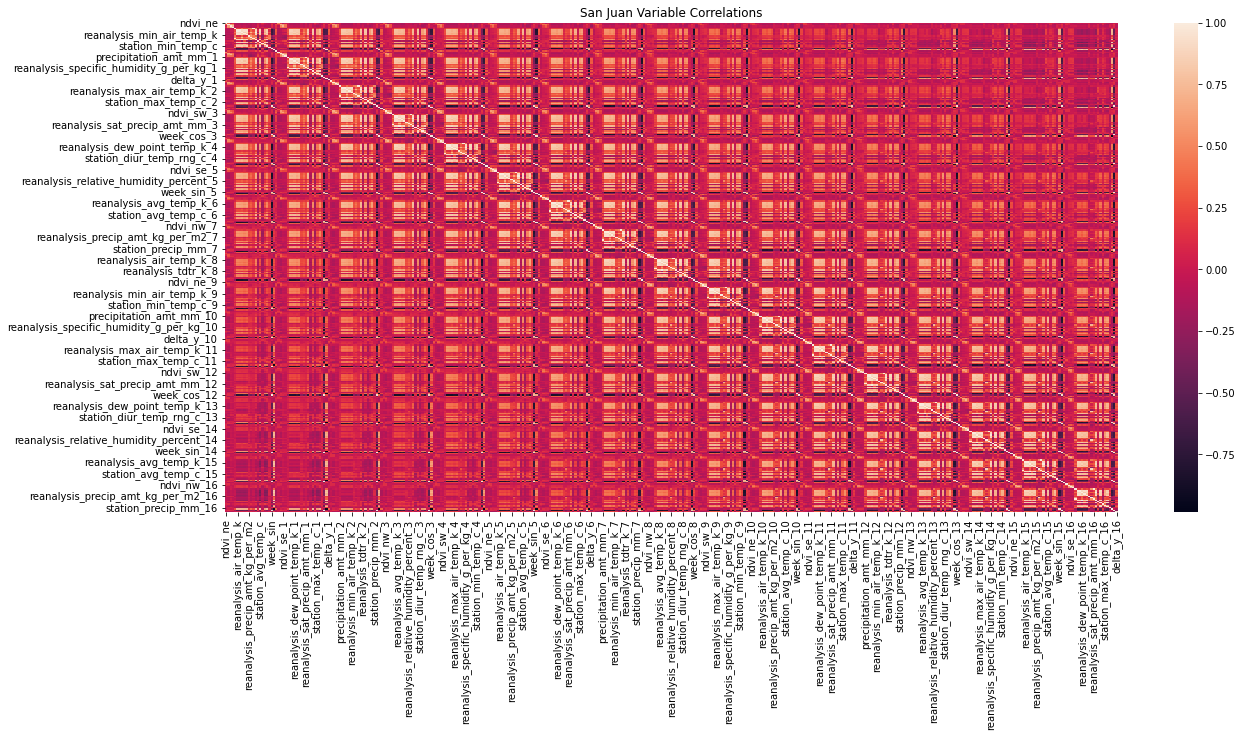

In [9]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [10]:
'''def chain_predict(model,x):
    #need to used last predicted y as input for next prediction
    xt = x.copy()
    preds = []
    #ser previous cases to zero
    xt['prev_total_cases'] = 0.0
    #make first prediction taking preset zero 
    #an update next column with prediction

    for i in range(xt.shape[0]):
        yt = model.predict([xt.iloc[i]])
        if i+1 < xt.shape[0]:
            xt['prev_total_cases'].iloc[i+1] = yt
        preds.append(yt[0])

    return preds'''

"def chain_predict(model,x):\n    #need to used last predicted y as input for next prediction\n    xt = x.copy()\n    preds = []\n    #ser previous cases to zero\n    xt['prev_total_cases'] = 0.0\n    #make first prediction taking preset zero \n    #an update next column with prediction\n\n    for i in range(xt.shape[0]):\n        yt = model.predict([xt.iloc[i]])\n        if i+1 < xt.shape[0]:\n            xt['prev_total_cases'].iloc[i+1] = yt\n        preds.append(yt[0])\n\n    return preds"

In [11]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

9.221700050182246
22.995803252585784


In [12]:
sj_rf.feature_importances_

array([1.31066655e-04, 3.08715988e-02, 4.62741204e-01, 5.97974794e-03,
       2.63113943e-04, 9.06427105e-05, 1.66673418e-04, 3.22412156e-04,
       1.43894125e-04, 1.00496134e-04, 6.64681644e-04, 1.23043097e-04,
       1.45746145e-04, 6.29253947e-04, 4.15558802e-04, 1.31138368e-05,
       3.59719786e-03, 2.39702235e-05, 6.23195595e-05, 1.25580633e-04,
       0.00000000e+00, 0.00000000e+00, 8.85596514e-02, 1.02167499e-04,
       1.78792238e-04, 8.26531004e-02, 2.81215976e-04, 6.28398825e-05,
       2.09837120e-04, 2.94089650e-04, 7.54675785e-04, 1.54190044e-04,
       3.18612734e-04, 5.79412899e-04, 8.05907895e-05, 5.31340255e-05,
       4.81161984e-04, 1.67492610e-04, 6.71120836e-05, 1.28597216e-04,
       6.77097166e-05, 7.20228152e-05, 5.82369624e-04, 0.00000000e+00,
       1.07925397e-05, 5.12624793e-02, 7.44565685e-05, 2.50217214e-04,
       1.26778664e-02, 5.55383827e-04, 2.08369346e-05, 2.62534967e-04,
       1.69420332e-04, 8.05699720e-04, 2.04934242e-04, 1.54561818e-04,
      

<AxesSubplot:ylabel='cols'>

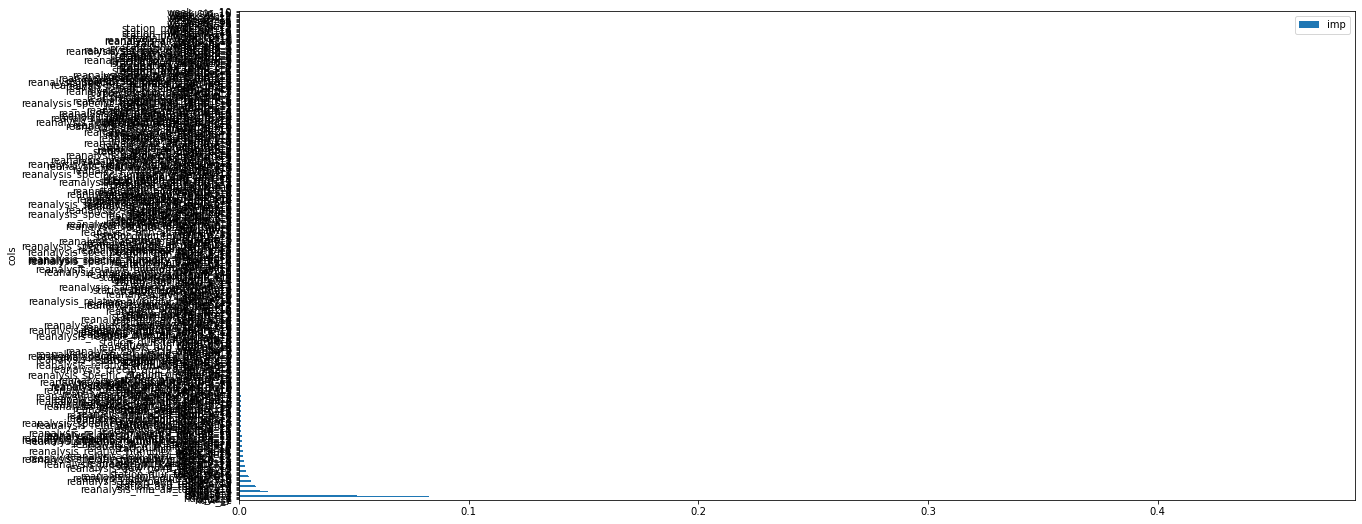

In [13]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [14]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

2.1490040632319385
7.855911328620762


In [15]:
iq_rf.feature_importances_

array([5.24013571e-04, 6.25539288e-04, 4.06772282e-04, 5.89288669e-04,
       5.58741547e-05, 2.04709451e-04, 9.08215259e-04, 8.06607979e-04,
       5.99808889e-05, 1.38653993e-03, 1.64356129e-04, 3.65652169e-05,
       8.24170688e-04, 2.08579380e-03, 1.11306804e-04, 3.53406545e-04,
       4.13286738e-04, 1.28200623e-04, 2.37236466e-03, 1.48099111e-04,
       1.95650759e-04, 3.75721070e-04, 5.45500660e-01, 1.87035568e-04,
       2.45173743e-04, 1.13727413e-04, 4.99084420e-04, 6.19776888e-04,
       2.92288461e-04, 4.30932727e-04, 1.08745646e-03, 2.80877637e-04,
       1.12229049e-03, 2.53713731e-05, 1.24784994e-04, 5.41542438e-04,
       1.78597365e-03, 6.61745949e-05, 1.95269266e-04, 1.19034611e-03,
       6.64945378e-04, 4.41237630e-04, 3.42197257e-04, 0.00000000e+00,
       0.00000000e+00, 9.83708039e-02, 1.23570853e-03, 1.56976921e-04,
       1.78231594e-04, 1.30078260e-04, 7.93011498e-05, 3.18550229e-04,
       3.04120222e-04, 1.00283166e-04, 1.26127544e-03, 2.35931559e-03,
      

<AxesSubplot:ylabel='cols'>

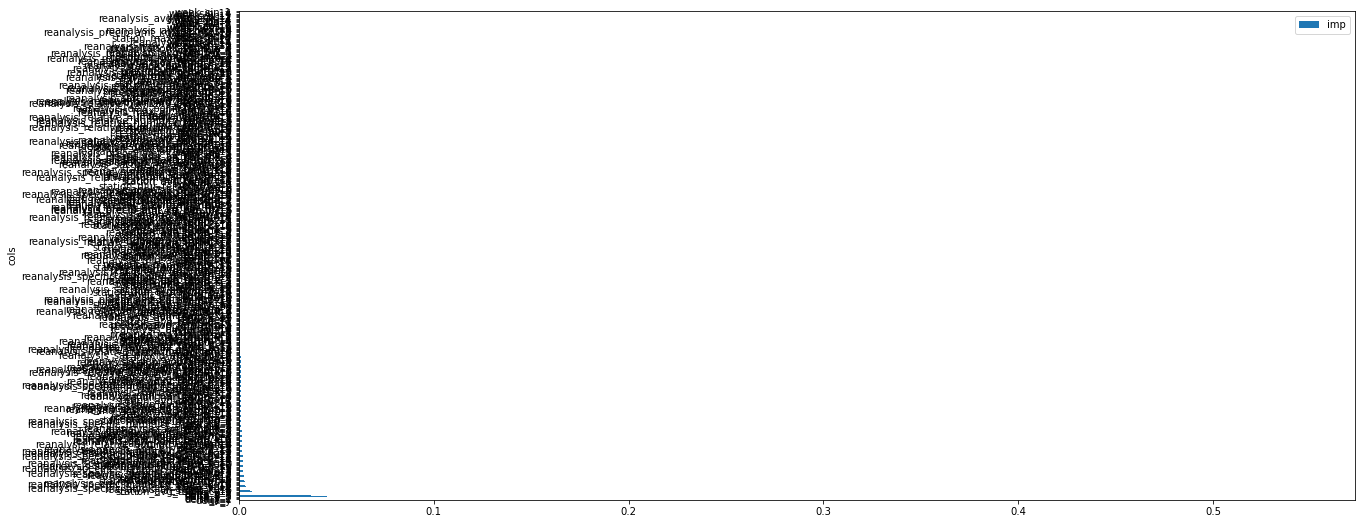

In [16]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

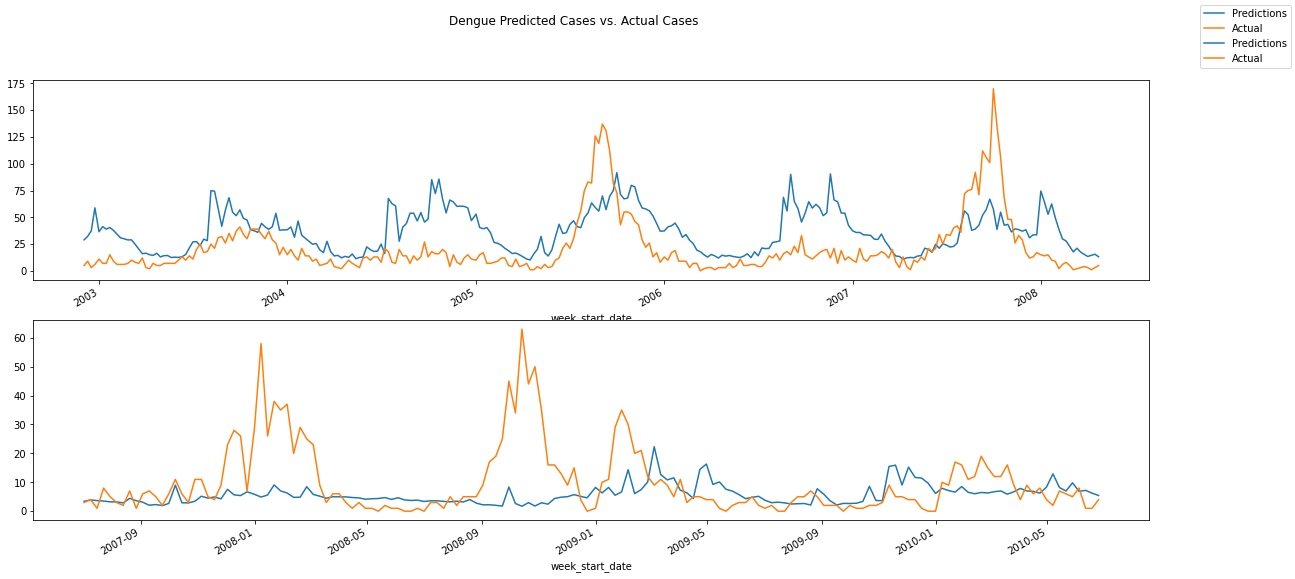

In [17]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [18]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [19]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                        sj_tminus=tminus,
                                        iq_tminus=tminus) 

In [20]:
sj_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_specific_humidity_g_per_kg_16,reanalysis_tdtr_k_16,station_avg_temp_c_16,station_diur_temp_rng_c_16,station_max_temp_c_16,station_min_temp_c_16,station_precip_mm_16,week_sin_16,week_cos_16,delta_y_16
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,...,14.383816,2.908398,28.149982,6.002462,30.230638,23.302494,729.594027,0.017642,-0.152901,2.378607
2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,...,14.514669,2.906030,28.145129,6.003328,30.353512,23.328819,688.693827,0.017150,-0.152117,2.331980
2008-05-13,-0.001500,-0.031051,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,...,14.645522,2.903661,28.140276,6.004193,30.476386,23.355144,647.793627,0.016658,-0.151332,2.285353
2008-05-20,0.052862,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,...,14.776375,2.901293,28.135424,6.005059,30.599260,23.381469,606.893427,0.016166,-0.150548,2.238726
2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,...,14.907229,2.898924,28.130571,6.005924,30.722134,23.407795,565.993227,0.015674,-0.149763,2.192099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,...,16.981429,2.457143,27.614286,5.742857,31.100000,23.900000,46.600000,-0.558647,0.829406,2.890784
2013-04-02,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,...,16.560000,2.228571,27.142857,5.885714,31.100000,23.300000,58.900000,-0.456629,0.889657,0.091183
2013-04-09,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,...,15.682857,2.200000,27.085714,6.300000,32.200000,22.800000,9.800000,-0.348202,0.937420,-13.722719


In [21]:
iq_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_specific_humidity_g_per_kg_16,reanalysis_tdtr_k_16,station_avg_temp_c_16,station_diur_temp_rng_c_16,station_max_temp_c_16,station_min_temp_c_16,station_precip_mm_16,week_sin_16,week_cos_16,delta_y_16
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,...,14.229820,11.515705,27.740219,8.369388,32.149461,33.204696,46.001106,-0.238017,-0.217840,-1.166963
2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,...,14.328216,11.400731,27.738120,8.517302,32.257082,32.440115,43.824492,-0.236155,-0.215050,-1.097187
2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,...,14.426611,11.285757,27.736021,8.665217,32.364703,31.675535,41.647879,-0.234293,-0.212260,-1.027410
2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,...,14.525007,11.170783,27.733922,8.813131,32.472324,30.910955,39.471265,-0.232431,-0.209470,-0.957633
2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,...,14.623402,11.055809,27.731823,8.961045,32.579945,30.146375,37.294651,-0.230569,-0.206680,-0.887856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,...,18.724286,9.528571,28.350000,9.050000,33.400000,22.400000,15.000000,0.652822,0.757511,-1.699283
2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,...,18.040000,7.785714,27.800000,8.600000,33.800000,22.400000,19.600000,0.737833,0.674983,0.363613
2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,...,18.465714,6.914286,27.120000,9.240000,33.000000,21.700000,33.300000,0.812487,0.582979,0.118480


In [22]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [23]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 22.995803252585784
iq 7.855911328620762


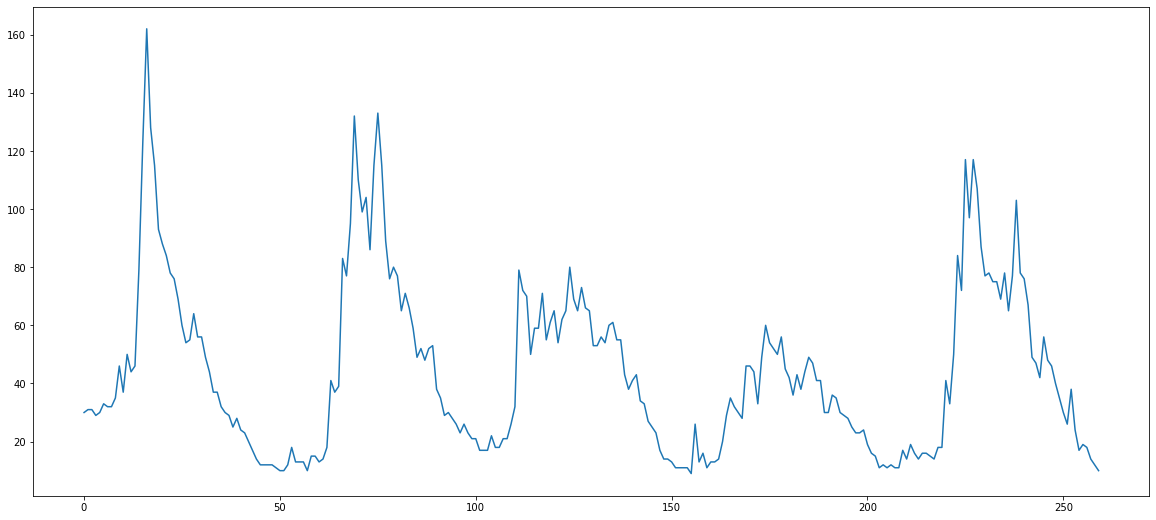

In [24]:
plt.plot(sj_predictions)

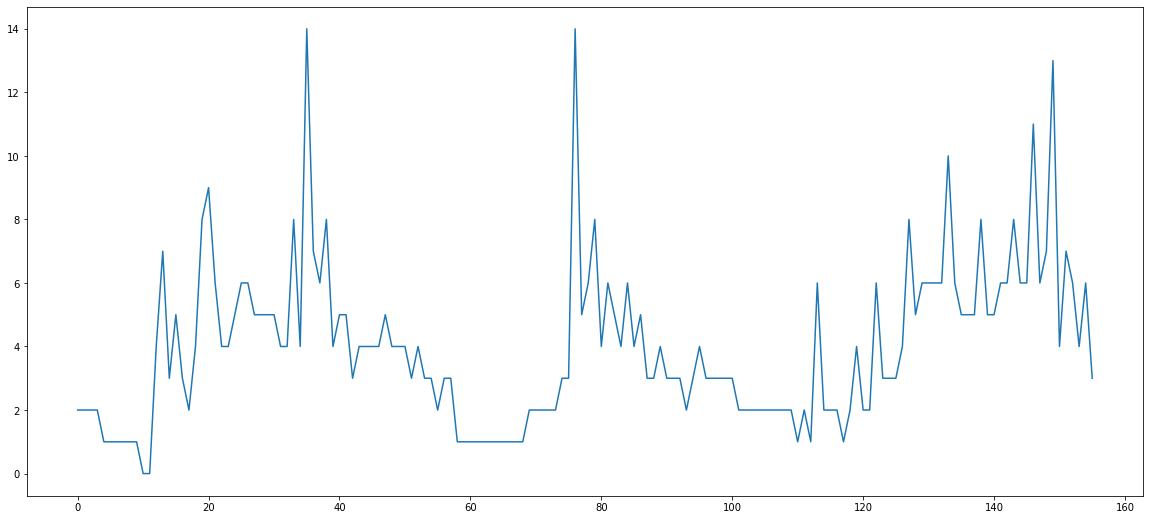

In [25]:
plt.plot(iq_predictions)